Image size: 960x540 pixels.


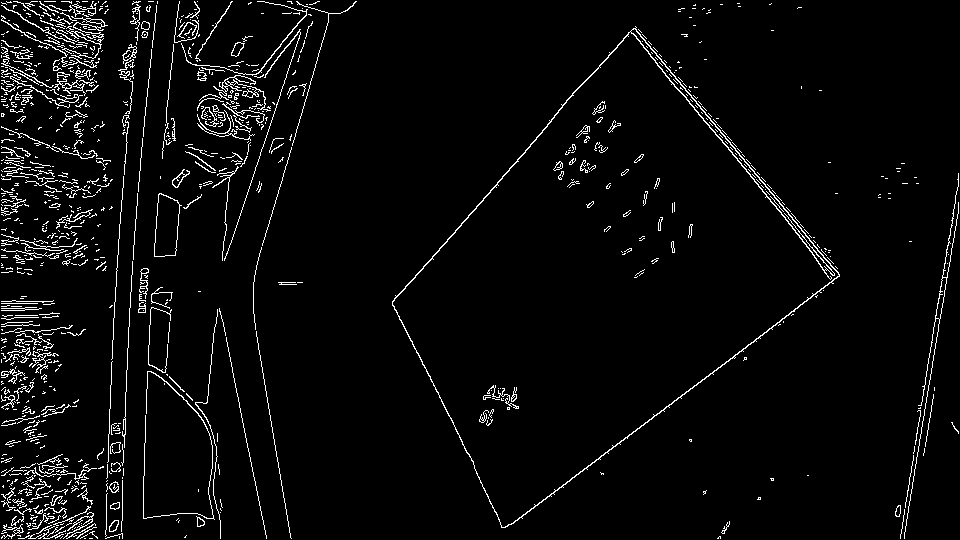

[[[635  26]]

 [[392 301]]

 [[501 527]]

 [[839 276]]]


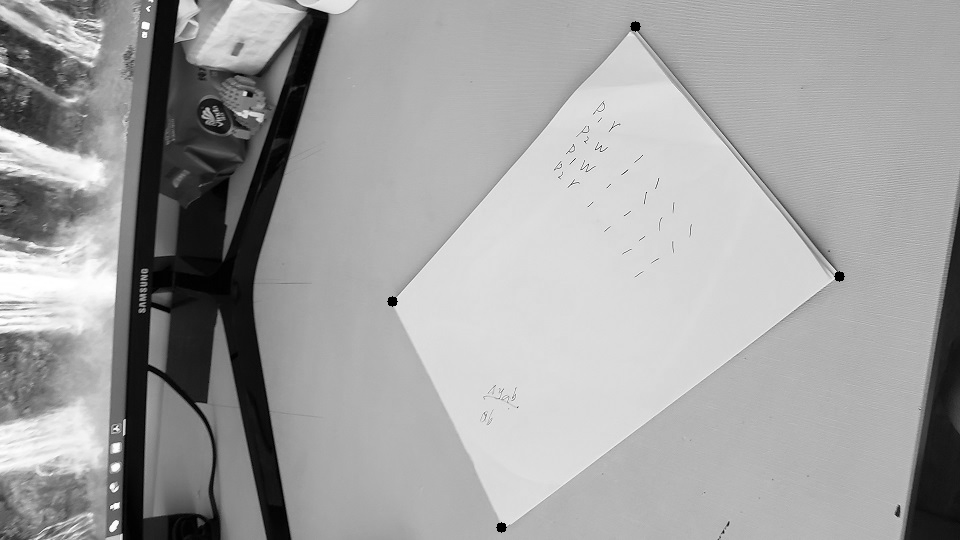

Canny edged in Hardware(PL): 960x540 pixels.


In [1]:
from PIL import Image
import numpy as np
import cv2 as cv
from IPython.display import display
from pynq import Xlnk
from pynq import Overlay

CannyEdge_design = Overlay("./bitstream/CannyEdge.bit")
dma = CannyEdge_design.axi_dma_0
CannyEdge = CannyEdge_design.canny_edge_0
image_path = "images/test.jpg"
original_image = Image.open(image_path)
#display(original_image)
pic_width, pic_height = original_image.size
print("Image size: {}x{} pixels.".format(pic_width, pic_height))
original_image = original_image.convert('L') #gray scale the loaded image
#display(original_image)
input_array = np.array(original_image)
xlnk = Xlnk()
in_buffer = xlnk.cma_array(shape=(pic_height, pic_width), 
                           dtype=np.uint8)
out_buffer = xlnk.cma_array(shape=(pic_height, pic_width), 
                            dtype=np.uint8)
np.copyto(in_buffer,input_array)
#in_buffer.nbytes = input_array.nbytes
buf_image = Image.fromarray(in_buffer)
#display(buf_image)
#print("Image size: {}x{} pixels.".format(pic_width, pic_height))
CannyEdge.write(0x14, pic_height) #rows
CannyEdge.write(0x1c, pic_width) #cols
CannyEdge.write(0x24, 20) #Data signal of threshold1
CannyEdge.write(0x2c, 100) #Data signal of threshold2
dma.sendchannel.transfer(in_buffer)
dma.recvchannel.transfer(out_buffer)    
CannyEdge.write(0x00,0x81) # start
dma.sendchannel.wait()
dma.recvchannel.wait()
result = Image.fromarray(out_buffer)
display(result)
img = np.asarray(result)
image , contours , hierarchy = cv.findContours ( img , cv.RETR_EXTERNAL , cv.CHAIN_APPROX_NONE  )
maxarea=0
index=0
i=0
for contour in contours:
    if cv.contourArea(contour)>maxarea:
        maxarea=cv.contourArea(contour)
        index=i
    i=i+1
testimg = np.asarray(original_image)

polyContour=cv.approxPolyDP(contours[index], 10, True);
print(polyContour)

cv.drawContours(testimg,polyContour,-1,(0,0,255),10)
outP=Image.fromarray(np.uint8(testimg))
display(outP)
cv.imwrite("images/testout.jpg",img)
print("Canny edged in Hardware(PL): {}x{} pixels.".format(pic_width, pic_height))
in_buffer.close()
out_buffer.close()
xlnk.xlnk_reset()